# Third run (Trying out epsilons)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### load the data

In [2]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/visualize_alpha/epsilon/adata_out.h5py"
ad = sc.read_h5ad(path)
ad

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 50000 × 1536
    obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set', 'image_id', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'image_nr', 'group', 'slice', 'in_sample', 'batch'
    uns: 'brain_area_scores', 'brain_area_target_f1', 'cell_transitions', 'converged', 'translation_matrices', 'translation_scores'
    obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords'

## Plot the performances w.r.t epsilons

0.076341


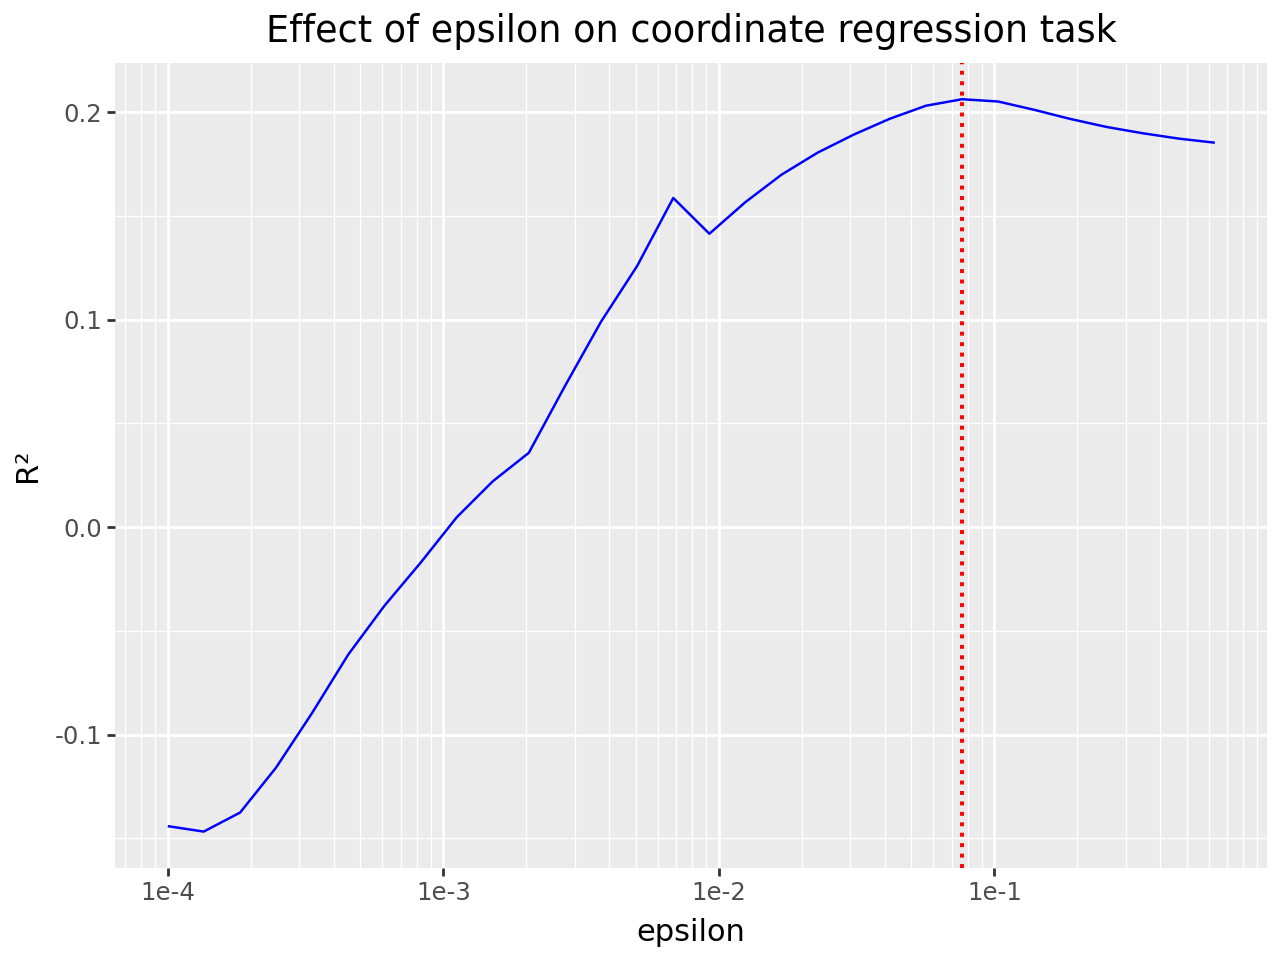

In [3]:
keys, values = zip(*ad.uns["translation_scores"].items())
df = pd.DataFrame(np.array((keys, values)).T.astype(float), columns = ["epsilon", "R²"])
max_epsilon = df.loc[df["R²"].idxmax(), "epsilon"]
print(max_epsilon)

plot = (
    ggplot(df, aes(x="epsilon", y="R²")) +
    geom_line(color="blue")+
    ggtitle("Effect of epsilon on coordinate regression task")+
    geom_vline(xintercept=max_epsilon, color = "red", linetype="dotted", size=0.8)+
    scale_x_continuous(trans = "log10")
)
plot

## Plot cell transitions

In [4]:
min_epsilon = str(df.loc[df["R²"].idxmin(), "epsilon"])
max_epsilon = str(max_epsilon)
min_epsilon, max_epsilon

('0.000135', '0.076341')

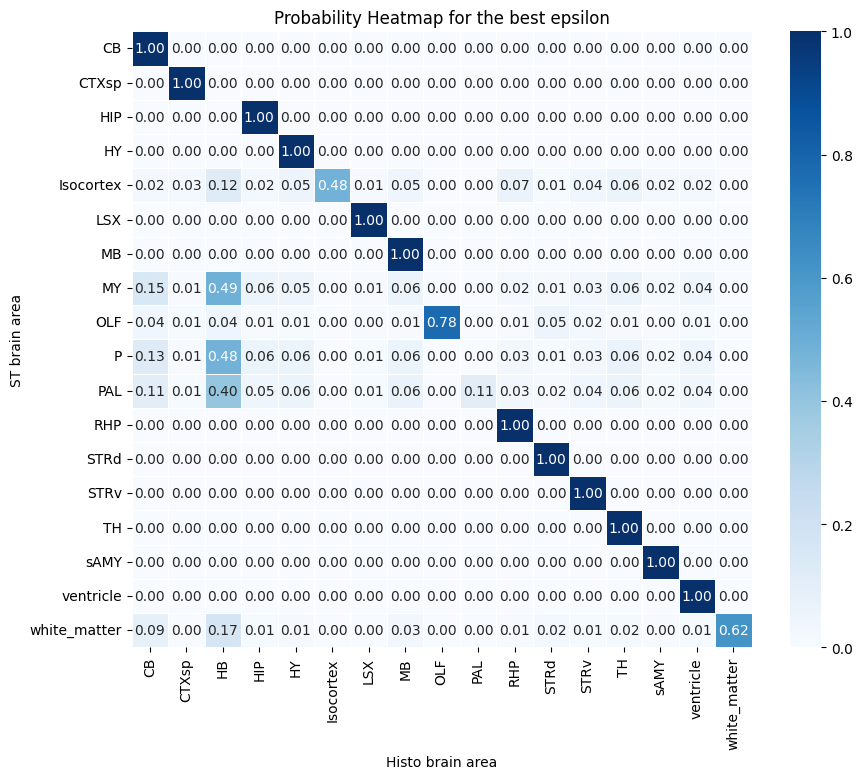

In [5]:
best_point = ad.uns["cell_transitions"]['0.076341']
worst_point = ad.uns["cell_transitions"]['0.000135']

plt.figure(figsize=(10, 8))
sns.heatmap(best_point, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Add labels
plt.ylabel("ST brain area")
plt.xlabel("Histo brain area")
plt.title("Probability Heatmap for the best epsilon")

# Show the plot
plt.show()

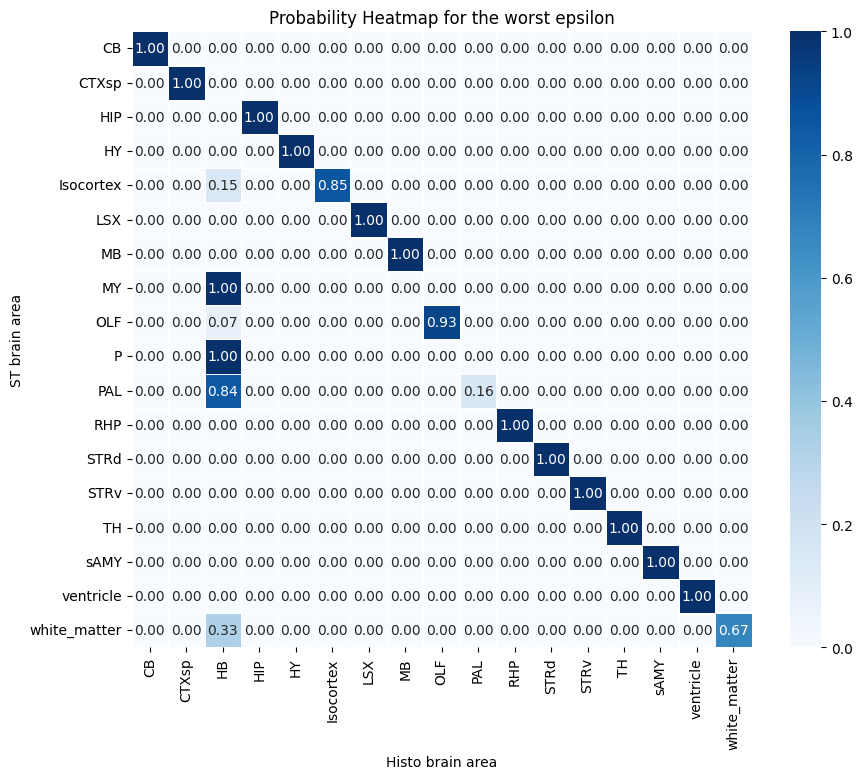

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(worst_point, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Add labels
plt.ylabel("ST brain area")
plt.xlabel("Histo brain area")
plt.title("Probability Heatmap for the worst epsilon")

# Show the plot
plt.show()

## Plot the transition matrices

In [19]:
best_t = ad.uns["translation_matrices"]['0.076341']
worst_t = ad.uns["translation_matrices"]['0.000135']

# Reorder the translation matrix by distance to origin
st_points = ad.obs.loc[:, ('x_st', 'y_st', 'z_st')].to_numpy()[:25_000]
histo_points = ad.obs.loc[:, ('x_st', 'y_st', 'z_st')].to_numpy()[25_000:]
st_dist = np.sqrt(np.sum(np.square(st_points), axis = -1)).flatten()
histo_dist = np.sqrt(np.sum(np.square(histo_points), axis = -1)).flatten()

st_ind = np.argsort(st_dist)
histo_ind = np.argsort(histo_dist)
st_ind

array([11121, 23798, 15148, ..., 20322, 10955, 17021])

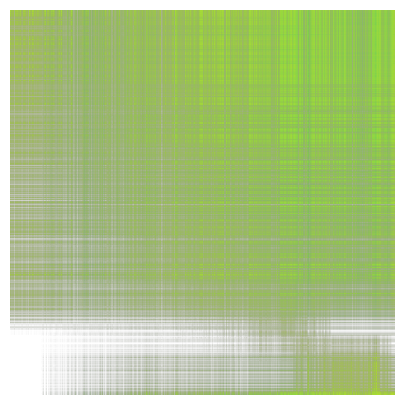

In [39]:
factor = 25_000 // 5_000
# sort by distance to origin
t = best_t[st_ind][:, histo_ind]
t = t[::factor, ::factor]
# t = (t/t.max() * 255).astype(np.uint8)

plt.figure(figsize=(5,5))
plt.imshow(t, norm=LogNorm())
plt.axis('off')
plt.show()

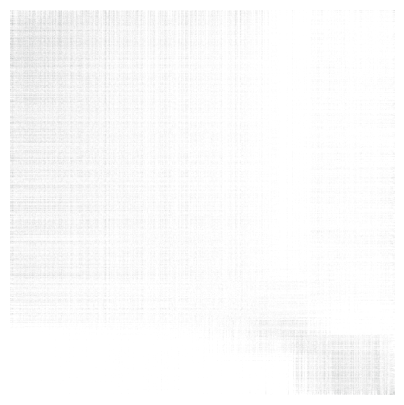

In [40]:
t = worst_t[st_ind][:, histo_ind]
t = t[::factor, ::factor]
# t = (t/t.max() * 255).astype(np.uint8)

plt.figure(figsize=(5,5))
plt.imshow(t, norm=LogNorm())
plt.axis('off')
plt.show()

## Plot the distributions

In [17]:
trans = []
for key in ad.uns["translation_matrices"].keys():
    t = ad.uns["translation_matrices"][key]
    new = []
    for i in range(0, len(t), 250):
        t_ = t[i, :]
        new.append(t_[t_ > 0]/t_.sum())
    trans.append(pd.DataFrame(dict(translation_probability = np.hstack(new))).assign(epsilon = key))

df_trans = pd.concat(trans, axis=0)
df_trans

,translation_probability,epsilon
0,2.837613e-39,0.000100
1,1.223026e-18,0.000100
2,9.101441e-14,0.000100
3,8.332070e-37,0.000100
4,8.016180e-19,0.000100
...,...,...
2499995,4.931352e-05,0.630957
2499996,5.576296e-05,0.630957
2499997,8.673697e-05,0.630957
2499998,2.857435e-09,0.630957


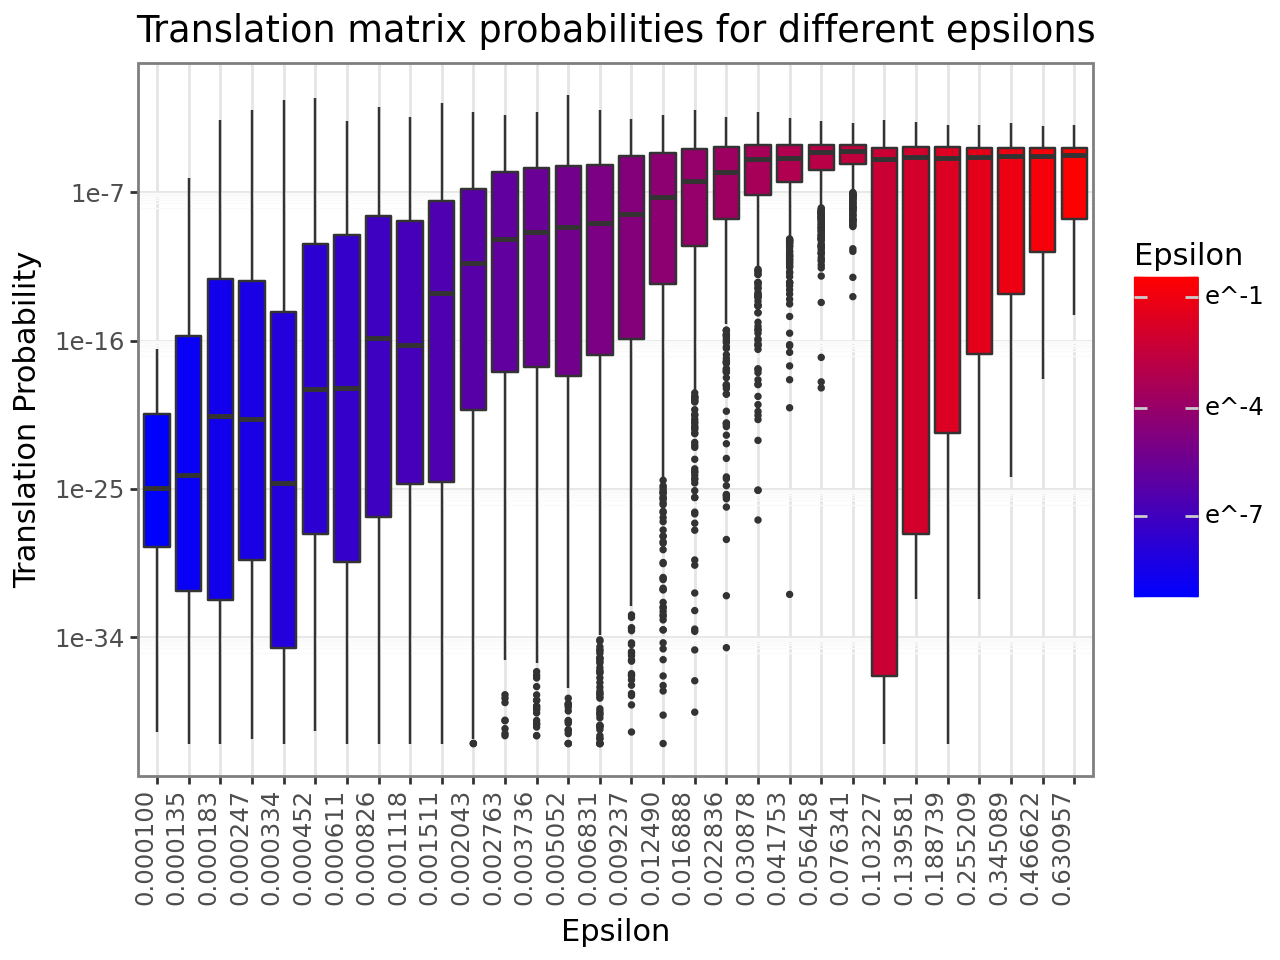

In [34]:
df = df_trans.sample(n=20000)
df['epsilon_numeric'] = df['epsilon'].astype(float)
plot = (
    ggplot(df, aes(x='epsilon', y='translation_probability', fill='epsilon_numeric'))
    # + geom_violin(width=1.0, alpha=0.5)
    + geom_boxplot(width=0.8, outlier_size=0.5)
    + scale_y_log10()
    + scale_fill_gradient(low="blue", high="red", trans = "log")
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
    + labs(x='Epsilon', y='Translation Probability', fill='Epsilon')
    + ggtitle("Translation matrix probabilities for different epsilons")
)

plot

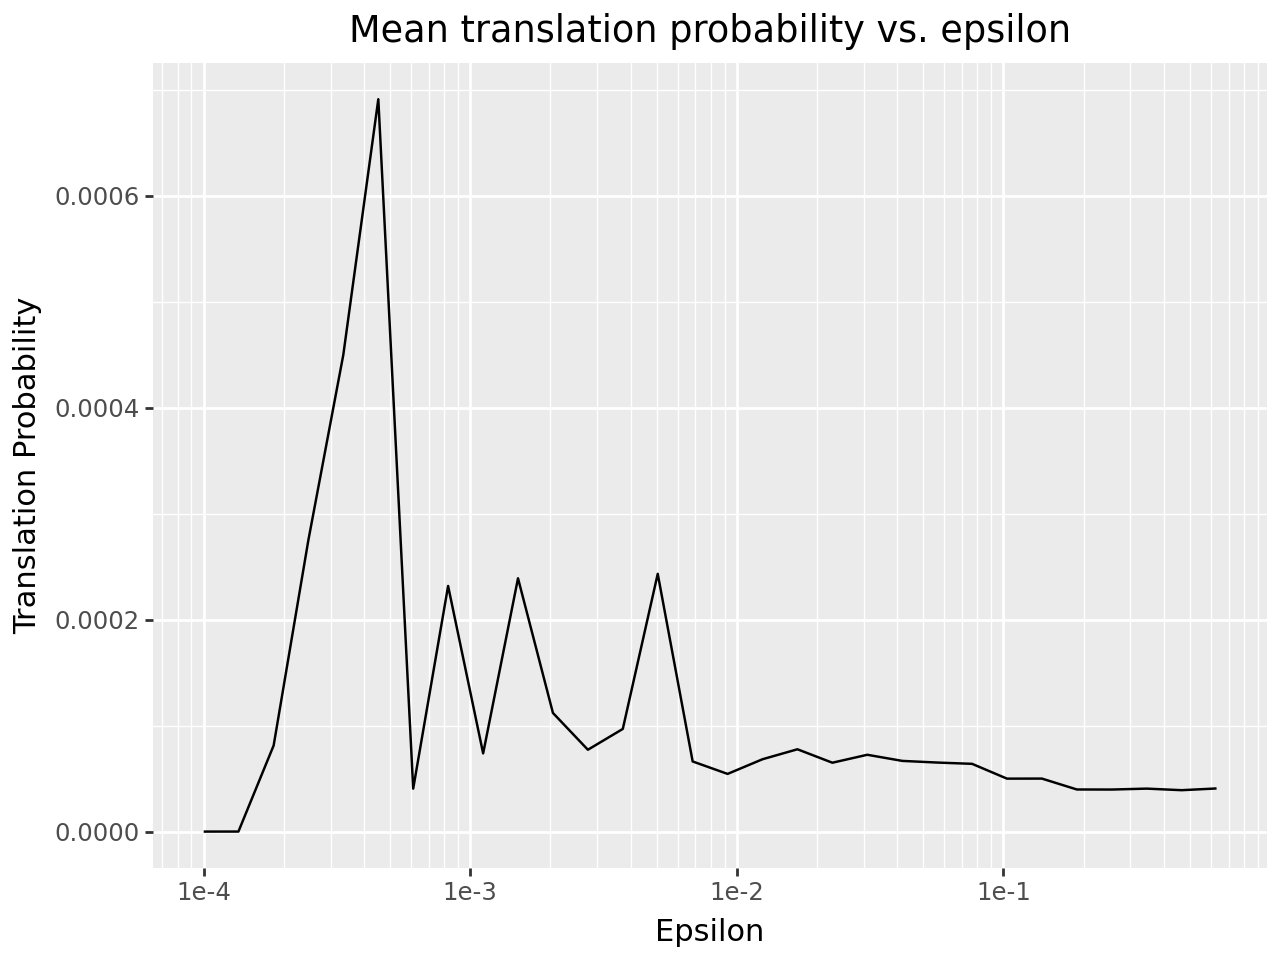

In [35]:
df2 = df.groupby("epsilon").mean()
ggplot(df2, aes(x="epsilon_numeric", y = "translation_probability")) + geom_line() + scale_x_log10() + ggtitle("Mean translation probability vs. epsilon") +labs(x='Epsilon', y='Translation Probability')

In [36]:
df2

,translation_probability,epsilon_numeric
epsilon,,
0.000100,1.890870e-18,0.000100
0.000135,2.827304e-08,0.000135
0.000183,8.122357e-05,0.000183
0.000247,2.749300e-04,0.000247
0.000334,4.496930e-04,0.000334
0.000452,6.909668e-04,0.000452
0.000611,4.051570e-05,0.000611
0.000826,2.317226e-04,0.000826
0.001118,7.376823e-05,0.001118


In [28]:
trans = []
for key in ad.uns["translation_matrices"].keys():
    t = ad.uns["translation_matrices"][key]
    new = []
    for i in range(0, len(t), 250):
        t_ = t[i, :]
        new.append((t_ > 0).sum())
    trans.append(pd.DataFrame(dict(n_non_zero = new)).assign(epsilon = key))

df = pd.concat(trans, axis=0)
df

,n_non_zero,epsilon
0,431,0.000100
1,958,0.000100
2,551,0.000100
3,160,0.000100
4,678,0.000100
...,...,...
95,25000,0.630957
96,25000,0.630957
97,25000,0.630957
98,25000,0.630957


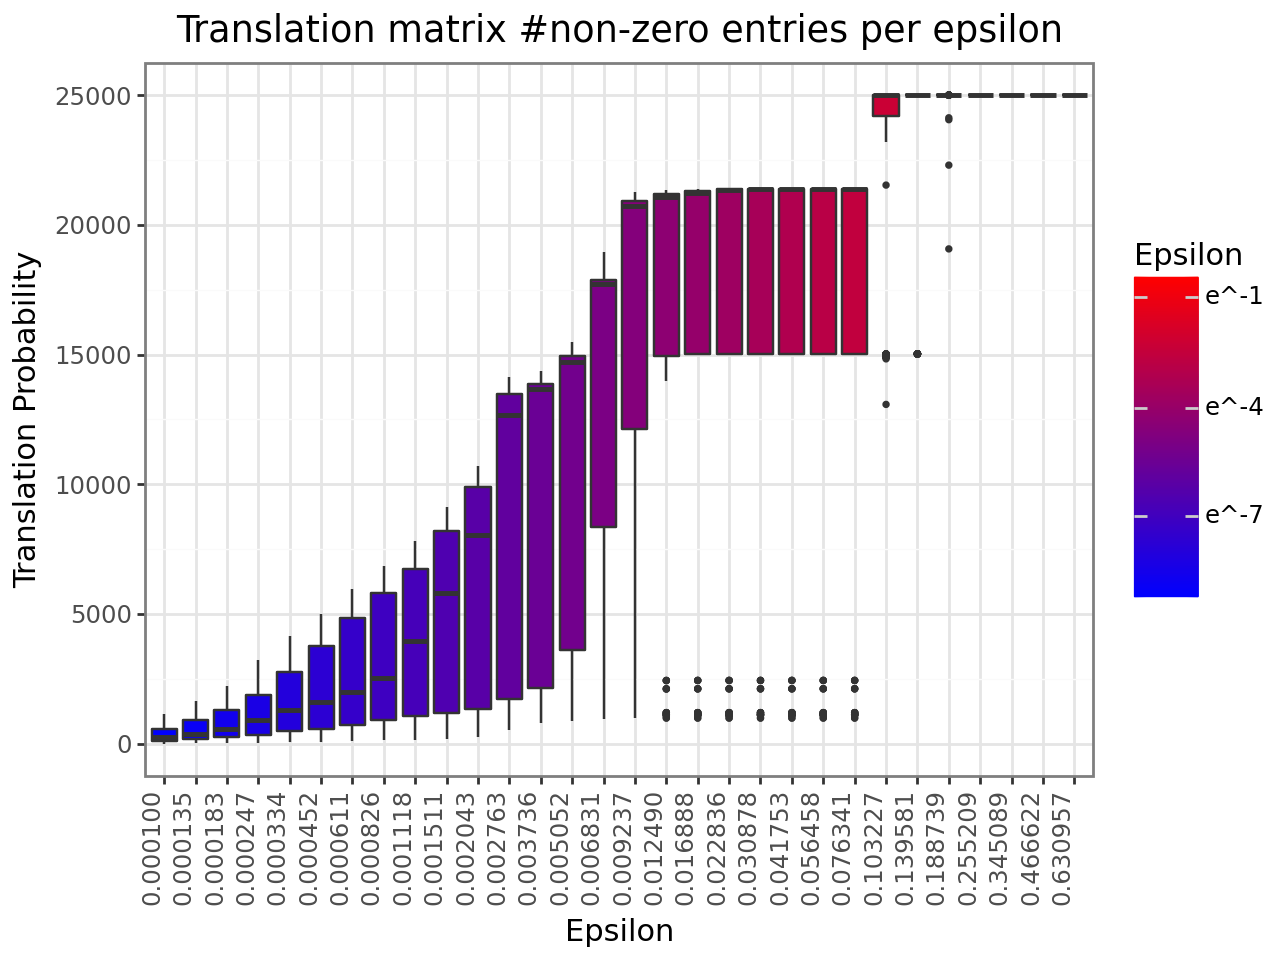

In [31]:
# df = df.sample(n=20000)
df['epsilon_numeric'] = df['epsilon'].astype(float)
plot = (
    ggplot(df, aes(x='epsilon', y='n_non_zero', fill='epsilon_numeric'))
    # + geom_violin(width=1.0, alpha=0.5)
    + geom_boxplot(width=0.8, outlier_size=0.5)
    # + scale_y_log10()
    + scale_fill_gradient(low="blue", high="red", trans = "log")
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
    + labs(x='Epsilon', y='Translation Probability', fill='Epsilon')
    + ggtitle("Translation matrix #non-zero entries per epsilon")
)

plot